The goal of this exploration is to determine whether we can use the aerodigestive microbiome to classify aspirators from non-aspirators.

Specifically, I want to know:

1. What is the baseline classifiability of aspirators vs. non-aspirators using 16S from each of the sites? [done]
1. How much better (or worse) are these classifiers if we include only the "shared" OTUs? [done]
    1. Does including both sites improve the single-site classifier based on the shared OTUs?
1. How much better (or worse) are these classifiers if we also add in beta diversity between certain sites?
1. What's the predictive power of combining classifiers?
    - i.e. if someone is classified as an aspirator by both the BAL and throat classifiers, what's the likelihood they're actually an aspirator?

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# to pretty print dataframes
from IPython.display import display

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, confusion_matrix
from sklearn.cross_validation import StratifiedKFold
from scipy import interp
from scipy.stats import fisher_exact

sns.set_style("white")
%matplotlib inline

## Load in data

In [3]:
# Raw data
fnotu = '/Users/claire/github/aspiration-analysis/data/clean/rosen.otu_table.clean'
fnmeta = '/Users/claire/github/aspiration-analysis/data/clean/rosen.metadata.clean'

df = pd.read_csv(fnotu, sep='\t', index_col=0)
meta = pd.read_csv(fnmeta, sep='\t', index_col=0)

# JSD
fnjsd = '/Users/claire/github/aspiration-analysis/data/analysis/jsd.txt'
jsd = pd.read_csv(fnjsd, sep='\t').dropna(how='all', axis=1)
jsd = jsd.query('patient_comp == "within"')

# Exchange
fnexchange = '/Users/claire/github/aspiration-analysis/data/analysis/exchange.txt'
exchange = pd.read_csv(fnexchange, sep='\t')
exchange = exchange.query('min_patients == 10')

# Seed random state
random_state = 12345

/Users/claire/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,19,20,24,25,26,27,28,29,30,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
exchange.head()

,exchange,min_patients,otu,p,patient_type,q,r,site_comparison,shared,diff_exchange
653,0.163934,10.0,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.001089,all_patients,0.005524,0.675188,bal_gastric,1.0,NaN
654,0.188525,10.0,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.373427,all_patients,0.500989,0.194664,bal_gastric,NaN,NaN
655,0.180328,10.0,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.127703,all_patients,0.218984,0.334839,bal_gastric,NaN,NaN
656,0.139344,10.0,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,0.085801,all_patients,0.162588,0.428922,bal_gastric,NaN,NaN
657,0.081967,10.0,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,0.510885,all_patients,0.623562,0.236364,bal_gastric,NaN,NaN


In [5]:
mbscol = 'mbs_consolidated'

## Tidy data

The goal is to have two tidy dataframes:

- tidyotu has the tidied up OTU table:
    - subject, sample ID, site, OTU, OTU labeled with the site, abundance, aspiration status
- tidyjsd has the tidied JSD (and is already made):
    - subject, site comparison, jsd value

To make our OTU-based classifiers, we will:

1. Query tidyotu for the site(s) of interest and drop any samples without aspiration metadata.
2. Pivot table from 1 to have subjects in rows and otu-w-site in columns
3. Assemble the output (Y) from the metadata, using a subject to aspiration status dict or something
    - here, I should probably check that all rows have an aspiration status...

To make the classifiers which incorporate only the shared OTUs, we will do the same thing but use the `shared` column in the `exchange` dataframe to first query OTUs that are shared. We'll have to be careful to match sites.

1. tidyotu.query(site == @sites).query(otu == @shared_otus).query(aspiration == @aspirations)
2. tidyotu.pivot(index=subject, columns=otu-w-site, values=abundance)
3. assemble Y vector, make classifier, profit

To make the classifiers which also include JSD, we'll do the same as above (either all OTUs or just the shared OTUs), and then add JSD:
1. Query and pivot the OTU table
2. Merge/join the pivoted OTU table (subject in index) on the tidyjsd.query(jsd == @jsd_of_interest)['jsd'] (which has subject in one of its columns)
3. assemble Y vector, make classifier, profit

### Tidy OTU table

In [6]:
tidyotu = pd.melt(df.reset_index(), id_vars='index', value_name='abun', var_name='otu')
tidyotu = tidyotu.rename(columns={'index': 'sample'})
tidyotu.head()

,sample,otu,abun
0,01-112-7GI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.025428
1,01-112-7RI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.013573
2,01-112-7TI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.000000
3,01-164-7GI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.000011
4,01-164-7RI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.010651


In [7]:
keepcols = [mbscol, 'site', 'subject_id']

tidyotu = tidyotu.merge(meta[keepcols], left_on='sample', right_index=True)
tidyotu.head()

,sample,otu,abun,mbs_consolidated,site,subject_id
0,01-112-7GI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.025428,NaN,gastric_fluid,01-112-7
628,01-112-7GI,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,NaN,gastric_fluid,01-112-7
1256,01-112-7GI,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,NaN,gastric_fluid,01-112-7
1884,01-112-7GI,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.000000,NaN,gastric_fluid,01-112-7
2512,01-112-7GI,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,NaN,gastric_fluid,01-112-7


In [8]:
# Add column with OTUs labeled with their site
tidyotu['otu_w_site'] = tidyotu.apply(lambda row: row['otu'] + '--' + row['site'], axis=1)

### Tidy JSD

In [9]:
# Make tidyjsd
site_comparisons = ['bal_throat', 'bal_gastric', 'throat_gastric']
tidyjsd = jsd.query('site_comparison == @site_comparisons')[['subject', 'site_comparison', 'jsd']]
tidyjsd.head()

,subject,site_comparison,jsd
1,01-112-7,throat_gastric,0.991109
1879,01-164-7,throat_gastric,0.091681
4369,01-173-4,throat_gastric,0.516359
11136,01-230-9,throat_gastric,0.973974
11744,01-230-9,throat_gastric,0.982211


### Aspiration map

i.e dictionary that goes from subject to aspiration status, where aspirators are 1 and normal are 0

In [10]:
def binarize_asp(a):
    if a == 'Aspiration/Penetration':
        return 1
    elif a == 'Normal':
        return 0
    else:
        return np.nan
aspdict = dict(zip(meta['subject_id'], meta[mbscol].map(lambda x: binarize_asp(x))))
aspdict.items()[0:10]

[('13-164-7', nan),
 ('04-080-7', nan),
 ('04-294-8', 1.0),
 ('01-299-7', nan),
 ('04-084-1', nan),
 ('04-167-8', 1.0),
 ('01-299-8', nan),
 ('04-087-1', nan),
 ('042-6-F1', nan),
 ('02-111-4', 0.0)]

## Make single site classifiers

Can we classify aspirators using their communities from one site? What happens if we limit the features to only the shared OTUs in that site? What happens if we add beta diversity to these classifiers?

Note: the "shared" OTUs and beta diversity have three permutations: one for each of the two site comparisons and one with both (e.g. for the lung community: bal_throat, bal_gastric, bal_throat and bal_gastric)

In [41]:
def cv_and_roc(rf, X, Y, num_cv=5, random_state=None):
    """
    Perform cross validated training and testing and return the aggregate
    interpolated ROC curve and confusion matrices.

    Parameters
    ----------
    rf : any sklearn classifier object
    X : array-like or sparse matrix, shape = [n_samples, n_features]
        The input samples to be split into train and test folds and
        cross-validated.
    Y : list or array
        array-like, shape = [n_samples] or [n_samples, n_outputs]
        The target values (class labels in classification).
    num_cv : int (default: 5)
        number of cross-validation folds
    random_state : int (default 12345)
        random state seed for StratifiedKFold

    Returns
    -------
    d : dict with the following keys:
        'roc_auc': area under the ROC curve
        'conf_mat': confusion matrix array, looks like:
                              pred
                             0   1
                    true  0  -   -
                          1  -   -
        'fisher_p': fisher exact pvalue of conf_mat above
        'y_probs': probability of being class 1
        'y_trues': true labels
        'mean_fpr', 'mean_tpr': interpolated values used to build ROC curve

    """
    if isinstance(Y, list):
        Y = np.asarray(Y)
    cv = StratifiedKFold(Y, num_cv, shuffle=True, random_state=random_state)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    conf_mat = np.asarray([[0,0],[0,0]])
    y_probs = np.empty_like(Y)
    y_predictions = np.empty_like(Y)

    for train_index, test_index in cv:
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        probs = rf.fit(X_train, Y_train).predict_proba(X_test)[:,1]
        preds = rf.predict(X_test)

        # Store probability and predicted values for X_test
        y_probs[test_index] = probs
        y_predictions[test_index] = preds

        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(Y_test, probs)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        
        # Compute confusion matrix
        conf_mat += confusion_matrix(Y_test, preds, labels=[0,1])

    mean_tpr /= len(cv)
    roc_auc = auc(mean_fpr, mean_tpr)

    _, fisher_p = fisher_exact(conf_mat)

    return {i: j for i, j in
            zip(('roc_auc', 'conf_mat', 'mean_fpr', 'mean_tpr',
                'fisher_p', 'y_prob', 'y_predictions', 'y_true'),
               (roc_auc, conf_mat, mean_fpr, mean_tpr, fisher_p,
               y_probs, y_predictions, Y))}


### Single site classifiers, 16S only

In [30]:
sites = ['bal', 'gastric_fluid', 'throat_swab']
results = {}

for site in sites:
    tmpotu = tidyotu.query('site == @site')\
                    .dropna(subset=[mbscol])\
                    .pivot(index='subject_id', columns='otu_w_site', values='abun')
    X = tmpotu.values
    Y = [aspdict[i] for i in tmpotu.index]
    rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
    results[site] = cv_and_roc(rf, X, Y, random_state=random_state)
    results[site]['patients'] = tmpotu.index

In [31]:
for site in results:
    print(site)
    print('AUC = {:.2f}, fisher p = {:.3f}'.format(results[site]['roc_auc'], results[site]['fisher_p']))
    print(results[site]['conf_mat'])
    print('')

throat_swab
AUC = 0.69, fisher p = 0.030
[[39  8]
 [24 15]]

bal
AUC = 0.67, fisher p = 0.024
[[28 16]
 [13 22]]

gastric_fluid
AUC = 0.65, fisher p = 0.098
[[39 17]
 [23 21]]



### Single site classifiers, 16S only - shared OTUs only

In [88]:
exchange.query('patient_type == "all_patients"').query('shared == 1').head()

,exchange,min_patients,otu,p,patient_type,q,r,site_comparison,shared,diff_exchange
653,0.163934,10.0,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.001089,all_patients,0.005524,0.675188,bal_gastric,1.0,NaN
660,0.106557,10.0,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,0.016537,all_patients,0.048239,0.648352,bal_gastric,1.0,NaN
667,0.163934,10.0,k__Bacteria;p__Bacteroidetes;c__Flavobacteriia...,0.008704,all_patients,0.029032,0.569925,bal_gastric,1.0,NaN
669,0.081967,10.0,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.028883,all_patients,0.073260,0.684848,bal_gastric,1.0,NaN
670,0.180328,10.0,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.000464,all_patients,0.002659,0.682665,bal_gastric,1.0,NaN


In [89]:
tidyotu.head()

,sample,otu,abun,mbs_consolidated,site,subject_id,otu_w_site
0,01-112-7GI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.025428,NaN,gastric_fluid,01-112-7,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...
628,01-112-7GI,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,NaN,gastric_fluid,01-112-7,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
1256,01-112-7GI,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,NaN,gastric_fluid,01-112-7,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
1884,01-112-7GI,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.000000,NaN,gastric_fluid,01-112-7,k__Bacteria;p__Actinobacteria;c__Actinobacteri...
2512,01-112-7GI,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,NaN,gastric_fluid,01-112-7,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...


In [97]:
# Actually, do all comparisons. The one that doesn't include the site should be worse than the others...
## site --> which sites OTUs can be shared across
#comp_dict = {'bal': ['bal_throat', 'bal_gastric'],
#             'gastric_fluid': ['bal_gastric', 'throat_gastric'],
#             'throat_swab': ['bal_throat', 'throat_gastric']}

for site in sites:
    for site_comp in site_comparisons:
        shared_otus = exchange.query('site_comparison == @site_comp')\
                              .query('shared == 1')\
                              ['otu'].tolist()

        tmpotu = tidyotu.query('site == @site')\
                        .dropna(subset=[mbscol])\
                        .query('otu == @shared_otus')\
                        .pivot(index='subject_id', columns='otu_w_site', values='abun')

        X = tmpotu.values
        Y = [aspdict[i] for i in tmpotu.index]
        rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
        k = site + '-' + site_comp + '_shared'
        results[k] = cv_and_roc(rf, X, Y, random_state=random_state)
        results[k]['patients'] = tmpotu.index

In [101]:
keys = []
for site in sites:
    keys.append(site)
    for site_comp in site_comparisons:
        keys.append(site + '-' + site_comp + '_shared')

for key in keys:
    print(key)
    print('AUC = {:.2f}, fisher p = {:.3f}'.format(results[key]['roc_auc'], results[key]['fisher_p']))
    print(results[key]['conf_mat'])
    print('')

bal
AUC = 0.67, fisher p = 0.024
[[28 16]
 [13 22]]

bal-bal_throat_shared
AUC = 0.69, fisher p = 0.107
[[30 14]
 [17 18]]

bal-bal_gastric_shared
AUC = 0.64, fisher p = 0.171
[[28 16]
 [16 19]]

bal-throat_gastric_shared
AUC = 0.70, fisher p = 0.013
[[28 16]
 [12 23]]

gastric_fluid
AUC = 0.65, fisher p = 0.098
[[39 17]
 [23 21]]

gastric_fluid-bal_throat_shared
AUC = 0.50, fisher p = 0.840
[[33 23]
 [27 17]]

gastric_fluid-bal_gastric_shared
AUC = 0.64, fisher p = 0.149
[[38 18]
 [23 21]]

gastric_fluid-throat_gastric_shared
AUC = 0.55, fisher p = 0.198
[[41 15]
 [26 18]]

throat_swab
AUC = 0.69, fisher p = 0.030
[[39  8]
 [24 15]]

throat_swab-bal_throat_shared
AUC = 0.66, fisher p = 0.042
[[35 12]
 [20 19]]

throat_swab-bal_gastric_shared
AUC = 0.70, fisher p = 0.061
[[37 10]
 [23 16]]

throat_swab-throat_gastric_shared
AUC = 0.66, fisher p = 0.039
[[36 11]
 [21 18]]



### Conclusion

Doing feature selection by using only the shared OTUs doesn't really seem to do much. If anything, it makes the classifiers worse.

## Positive predictive value of combining different classifiers

If a patient is predicted as aspirator by both the throat and BAL classifiers, what's the likelihood they're truly aspirators?

In [64]:
classifiers = ['throat_swab', 'bal', 'gastric_fluid']

k = 'throat_swab'
pd.DataFrame(columns=['true', 'pred', 'prob'], 
             data=np.array((results[k]['y_true'], results[k]['y_predictions'], results[k]['y_prob'])).T,
             index=results[k]['patients']).head()


,true,pred,prob
subject_id,,,
02-096-6,0.0,0.0,0.250
02-098-5,0.0,0.0,0.304
02-111-4,0.0,0.0,0.335
02-120-4,0.0,0.0,0.446
02-143-2,1.0,0.0,0.336


Make a dataframe with patient-wise results: indices are the subjects, columns are the predictions from each classifier (as well as the true value)

In [78]:
patient_results = pd.DataFrame(columns=classifiers, 
                               index=set([i for k in classifiers for i in results[k]['patients']]))
for k in classifiers:
    pts = results[k]['patients']
    patient_results.loc[pts, k] = results[k]['y_predictions']
    patient_results.loc[pts, 'true'] = results[k]['y_true']
patient_results.head()

,throat_swab,bal,gastric_fluid,true
04-167-8,NaN,NaN,0,1.0
02-111-4,0,0,0,0.0
04-126-4,0,0,0,0.0
04-110-8,0,0,0,0.0
04-157-4,0,1,1,1.0


Look at the sensitivity, specificity, positive, and negative predictive values for the throat classifier, the BAL classifier, and the combination classifier. [Wiki](https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values#Worked_example)

In [141]:
def fill_conf_mat(conf_mat):
    """
    Add sensitivy/specificity and positive/negative predictive values 
    to a confusion matrix.
    
    conf_mat is a numpy array. It is turned into a pandas DataFrame.    
    Rows will be labeled 'true 0', 'true 1' and columns 'pred 0' and 'pred 1'.
    """
    # Confusion matrix: rows are the true labels, columns are the predicted labels
    conf_mat = pd.DataFrame(conf_mat)
    conf_mat.columns = ['pred 0', 'pred 1']
    conf_mat.index = ['true 0', 'true 1']
    ppv = conf_mat.loc['true 1', 'pred 1'] / float(conf_mat['pred 1'].sum())
    npv = conf_mat.loc['true 0', 'pred 0'] / float(conf_mat['pred 0'].sum())
    spec = conf_mat.loc['true 0', 'pred 0'] / float(conf_mat.loc['true 0'].sum())
    sens = conf_mat.loc['true 1', 'pred 1'] / float(conf_mat.loc['true 1'].sum())

    conf_mat.loc['pred_value', :] = [npv, ppv]
    conf_mat.loc[:, 'spec/sens'] = [spec, sens, np.nan]
    return conf_mat

In [151]:
# Fill out classifiers' confusion matrics
throat = fill_conf_mat(results['throat_swab']['conf_mat'])
bal = fill_conf_mat(results['bal']['conf_mat'])

print('throat classifier')
display(throat)
print('bal classifier')
display(bal)

throat classifier


,pred 0,pred 1,spec/sens
true 0,39.000000,8.000000,0.829787
true 1,24.000000,15.000000,0.384615
pred_value,0.619048,0.652174,NaN


bal classifier


,pred 0,pred 1,spec/sens
true 0,28.000000,16.000000,0.636364
true 1,13.000000,22.000000,0.628571
pred_value,0.682927,0.578947,NaN


In [148]:
## Now the combined classifier
combined = pd.DataFrame(index=['true 0', 'true 1'])
for thrpred in [0, 1]:
    for balpred in [0, 1]:
        colname = 'thr {}, bal {}'.format(thrpred, balpred)
        combined.loc['true 0', colname] = \
            patient_results.query('true == 0')\
                           .query('throat_swab == @thrpred')\
                           .query('bal == @balpred').shape[0] 
        combined.loc['true 1', colname] = \
            patient_results.query('true == 1')\
                           .query('throat_swab == @thrpred')\
                           .query('bal == @balpred').shape[0] 

fill_conf_mat(combined[['thr 0, bal 0', 'thr 1, bal 1']])

,pred 0,pred 1,spec/sens
true 0,20.000000,2.000000,0.909091
true 1,9.000000,10.000000,0.526316
pred_value,0.689655,0.833333,NaN


In [152]:
combined

,"thr 0, bal 0","thr 0, bal 1","thr 1, bal 0","thr 1, bal 1"
true 0,20.0,7.0,1.0,2.0
true 1,9.0,8.0,1.0,10.0


As Eric expected, our "combined" classifier is quite good. It has a fairly high positive predictive value (80%) and slightly lower negative predictive value (70%). It's also *very* specific (90%) but not particularly sensitive (50%).

So basically, if this test is positive then 80% of the time it'll be a correct prediction (i.e. true positive).

This test doesn't capture all aspirators, but when it returns a positive result (i.e. aspirator), then it's fairly likely that it's correct.

If the test gives you a negative, it's also fairly likely that it's correct. But more importantly, it's fairly unlikely to call a non-aspirator an aspirator. 

Basically, if you get called an aspirator by this classifier - it's probably worth doing a follow up radiographic test. If you get called a non-aspirator, then that's slightly less informative but also probably right... Depends on your other symptoms, I suppose

Also, this combination indicates that the throat and BAL classifiers contain different information. Adding them together doesn't just give you back the same as each one individually - it adds information to each individual one.

#### Combined classifier based on combination of both sites

The previous "combined" was a combination of the *decisions* of the two individual classifiers. How well does a classifier that incorporates both BAL and throat communities work?

In [38]:
balthr_otu = tidyotu.query('(site == "throat_swab") | (site == "bal")')\
                    .dropna(subset=[mbscol])\
                    .pivot(index='subject_id', columns='otu_w_site', values='abun')\
                    .dropna()

In [43]:
X = balthr_otu.values
Y = [aspdict[i] for i in balthr_otu.index]
rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
results['bal_throat_combined'] = cv_and_roc(rf, X, Y, random_state=random_state)
results['bal_throat_combined']['patients'] = balthr_otu.index
pd.DataFrame(results['bal_throat_combined']['conf_mat'])

,0,1
0,21,9
1,7,21


Oh, dang. For some reason I thought combining the two communities wouldn't work as well... The AUC isn't that much higher but this confusion matrix is much better! Let's actually look into this again...

## Classifiers based on multiple sites

In [47]:
for site1 in sites:
    for site2 in sites[sites.index(site1)+1:]:
        tmpotu = tidyotu.query('(site == @site1) | (site == @site2)')\
                    .dropna(subset=[mbscol])\
                    .pivot(index='subject_id', columns='otu_w_site', values='abun')\
                    .dropna()
        X = tmpotu.values
        Y = [aspdict[i] for i in tmpotu.index]
        rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
        k = site1 + '-and-' + site2 
        results[k] = cv_and_roc(rf, X, Y, random_state=random_state)
        results[k]['patients'] = balthr_otu.index       

In [49]:
for site1 in sites:
    for site2 in sites[sites.index(site1)+1:]:
        k = site1 + '-and-' + site2 
        print('{} : AUC = {:.3f}, p = {:.3f}'.format(k, results[k]['roc_auc'], results[k]['fisher_p']))
        display(pd.DataFrame(results[k]['conf_mat']))

bal-and-gastric_fluid : AUC = 0.671, p = 0.052


,0,1
0,31,10
1,17,15


bal-and-throat_swab : AUC = 0.827, p = 0.001


,0,1
0,21,9
1,7,21


gastric_fluid-and-throat_swab : AUC = 0.712, p = 0.025


,0,1
0,32,8
1,19,16


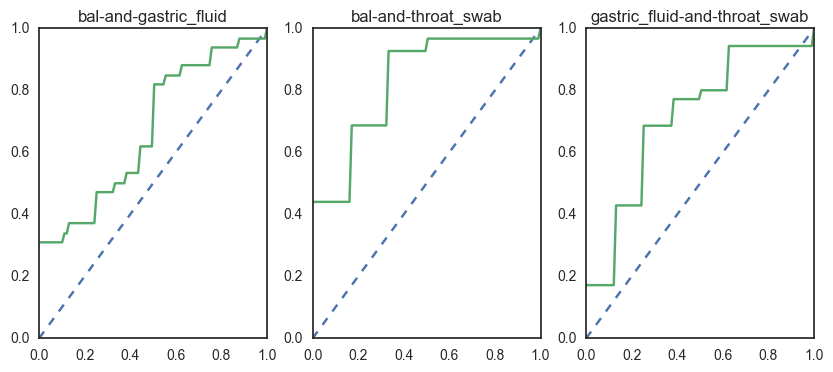

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(10,4))
i = 0
for site1 in sites:
    for site2 in sites[sites.index(site1)+1:]:
        k = site1 + '-and-' + site2 
        ax[i].plot([0, 1], [0, 1], '--')
        ax[i].plot(results[k]['mean_fpr'], results[k]['mean_tpr'])
        ax[i].set_title(k)
        i += 1

## Classifer next steps

- make classifiers based on all combinations of sites
- do it again, but with the labels shuffled
- do this like 10 times for each classifier
- plot AUC distribution (boxplots, or hist I guess...)

## Feature inspection

I don't think this will yield anything particularly insightful, but just in case: what features are driving each classifier?

Rebuild each classifier without splitting data, then look at what features are most important

Note: sciki-learn calculates feature importances based on the mean decrease in Gini impurity. For each feature, it is [calculated](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined) by "the error reduction of that node multiplied by the number of samples that were routed to the node" for all nodes that use that feature.

In [11]:
features = pd.DataFrame(columns=['classifier', 'feature', 'importance'])

sites = ['bal', 'gastric_fluid', 'throat_swab']

for site in sites:
    tmpotu = tidyotu.query('site == @site')\
                    .dropna(subset=[mbscol])\
                    .pivot(index='subject_id', columns='otu_w_site', values='abun')
    X = tmpotu.values
    Y = [aspdict[i] for i in tmpotu.index]
    rf = RandomForestClassifier(n_estimators=1000, random_state=random_state).fit(X, Y)
    tmpfeats = pd.DataFrame(data=rf.feature_importances_, columns=['importance'])
    tmpfeats['classifier'] = site
    tmpfeats['feature'] = tmpotu.columns
    features = pd.concat((features, tmpfeats), ignore_index=True)


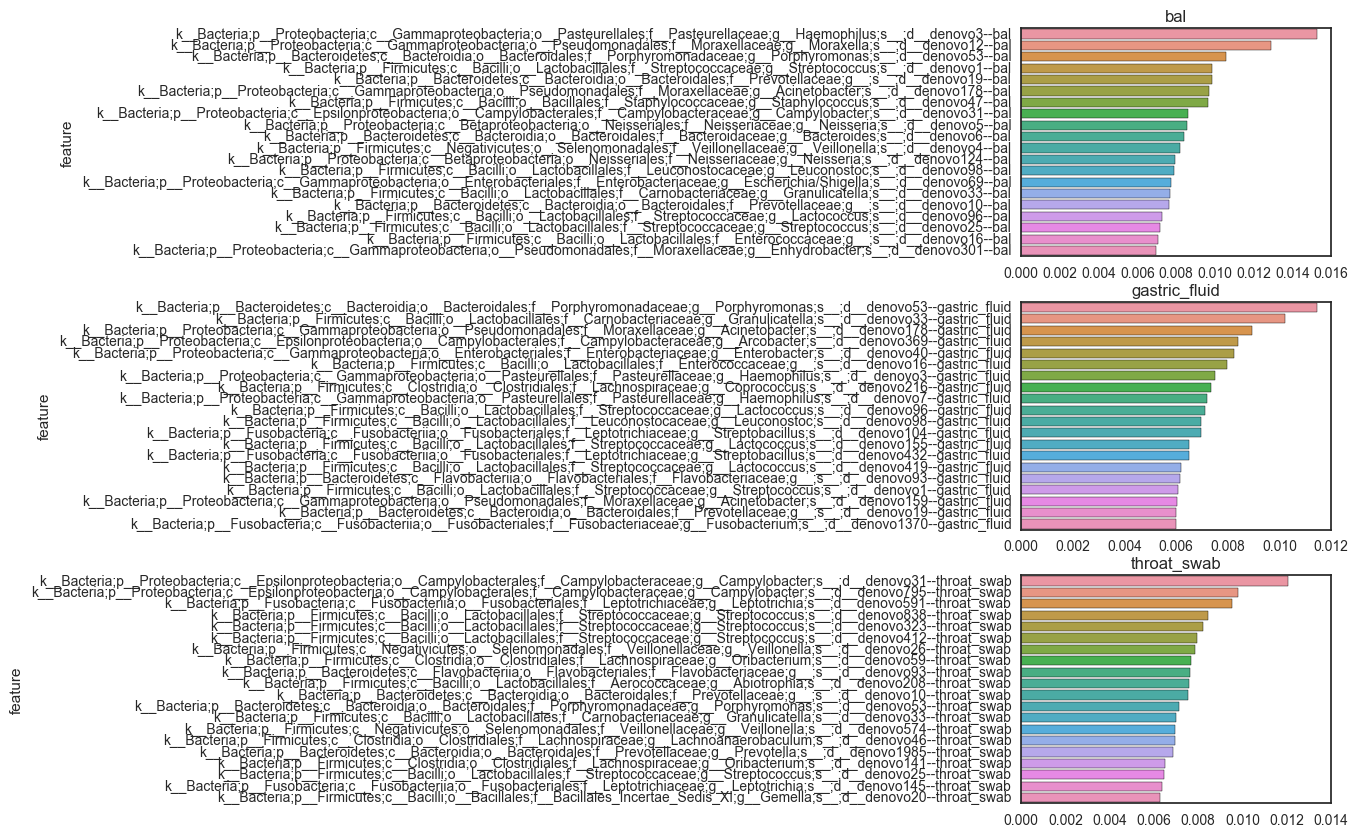

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(4,10))
i = 0
for g, subdf in features.groupby('classifier'):
    subdf = subdf.sort_values(by='importance', ascending=False)
    sns.barplot(x='importance', y='feature', data=subdf.head(20), ax=ax[i])
    ax[i].set_title(g)
    ax[i].set_xlabel('')
    i += 1

In [13]:
# Plot relative abundaces of top 5 features for each classifier
tidyotu['log_abun'] = tidyotu['abun'].map(lambda x: np.log10(x+1e-8))

In [14]:
def plot_five_feats(subdf, tidyotu):
    """
    subdf has columns 'importance', and 'feature'. Five most
    important features are plotted.
    
    tidyotu has columns 'mbs_cnsolidated', 'log_abun', 'otu_w_site'
    and is tidy-format.
    """
    fig, ax = plt.subplots(1, 5, figsize=(12,3))
    i = 0
    subdf = subdf.sort_values(by='importance', ascending=False)
    for otu in subdf['feature'][0:5]:
        sns.boxplot(x='mbs_consolidated', y='log_abun',
                    data=tidyotu.query('otu_w_site == @otu').fillna('nan'),
                    order=['Aspiration/Penetration', 'Normal'],
                    ax=ax[i])
        sns.stripplot(x='mbs_consolidated', y='log_abun',
                      data=tidyotu.query('otu_w_site == @otu').fillna('nan'),
                      order=['Aspiration/Penetration', 'Normal'],
                      jitter=True, linewidth=0.5, ax=ax[i])
        ax[i].set_title(otu.split(';')[3] + '\n' + ';'.join(otu.split(';')[4:6]) + '\n' + ';'.join(otu.split(';')[-2:]),
                        fontsize='small')
        ax[i].set_xticklabels(['asp', 'norml'])
        i += 1
    fig.tight_layout()
    return fig, ax

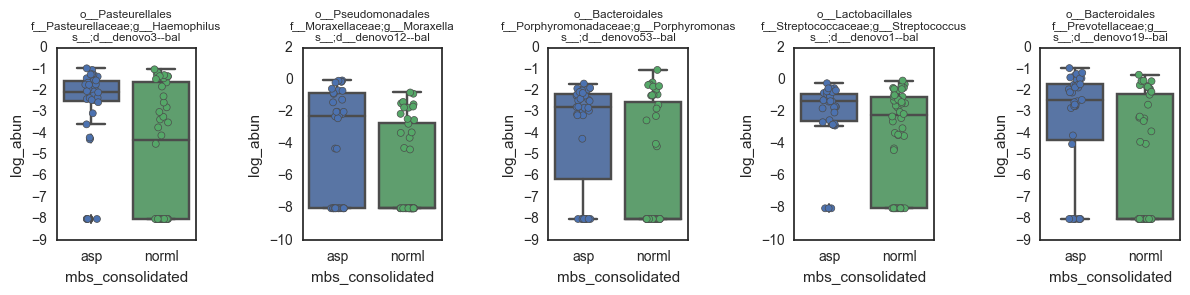

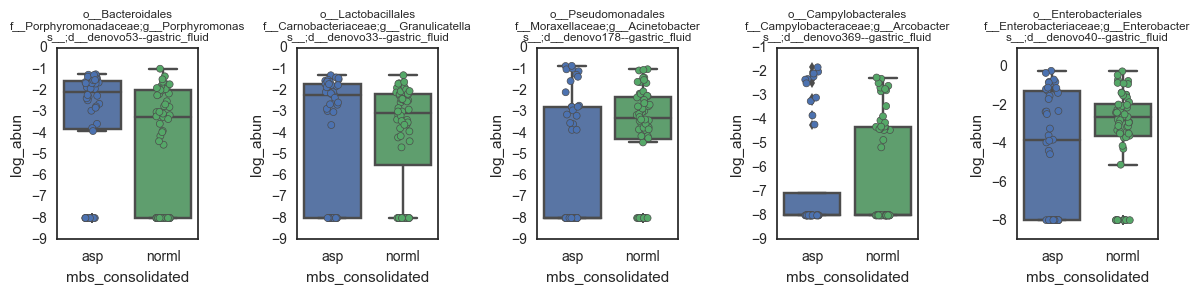

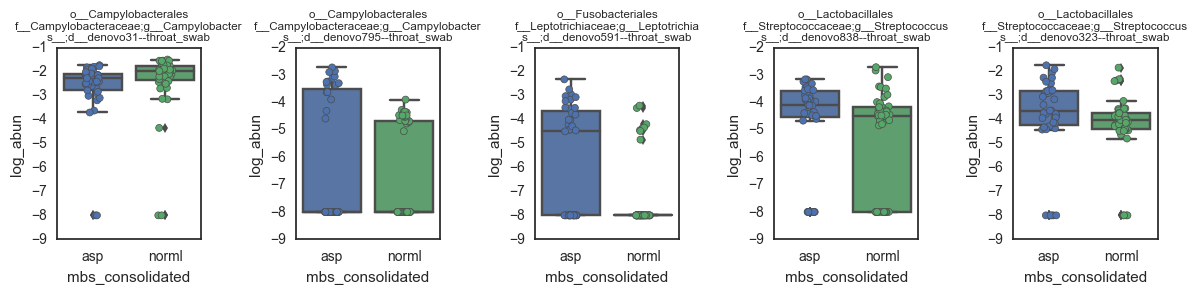

In [15]:
for g, subdf in features.groupby('classifier'):
    fig, ax = plot_five_feats(subdf, tidyotu)


Hm, nothing obvious comes out of these. It seems that maybe at times the classifier is finding features where the majority of one type has or doesn't have it. And many of these OTUs would probably be significant with univariate test.

But no clear pattern comes out from the top few features - it's not as if we found a smoking gun diagnostic. Whatever the perturbation, it's either more subtle/complex, or more heterogenous across patients.

### How do the features relate to the shared OTUs? 

e.g. plot rank abundance of features, indicate by coloring whether or not it's a shared OTU.

In [16]:
features.head()

,classifier,feature,importance
0,bal,k__;p__;c__;o__;f__;g__;s__;d__denovo120--bal,0.00005
1,bal,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,0.00000
2,bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1...,0.00048
3,bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1...,0.00019
4,bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1...,0.00000


In [17]:
exchange.head()

,exchange,min_patients,otu,p,patient_type,q,r,site_comparison,shared,diff_exchange
653,0.163934,10.0,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.001089,all_patients,0.005524,0.675188,bal_gastric,1.0,NaN
654,0.188525,10.0,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.373427,all_patients,0.500989,0.194664,bal_gastric,NaN,NaN
655,0.180328,10.0,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.127703,all_patients,0.218984,0.334839,bal_gastric,NaN,NaN
656,0.139344,10.0,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,0.085801,all_patients,0.162588,0.428922,bal_gastric,NaN,NaN
657,0.081967,10.0,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,0.510885,all_patients,0.623562,0.236364,bal_gastric,NaN,NaN


In [18]:
keepdict = {'throat_swab': ['throat_gastric', 'bal_throat'],
            'bal': ['bal_gastric', 'bal_throat'],
            'gastric_fluid': ['bal_gastric', 'throat_gastric']}
otu_labels = {}
# label the features df with sharedness status of OTUs
for site, subdf in features.groupby('classifier'):
    keepsites = keepdict[site]
    tmpexchange = exchange.query('shared == 1')\
                          .query('site_comparison == @keepsites')
    for otu, subexchange in tmpexchange.groupby('otu'):
        if subexchange.shape[0] > 1:
            label = '-'.join(subexchange['site_comparison'].sort_values().values)
        else:
            label = subexchange['site_comparison'].values[0]
        otu_labels[otu + '--' + site] = label    

In [19]:
def map_sharedness(otu, otu_labels):
    try:
        return otu_labels[otu]
    except:
        return 'nan'
features['shared_type'] = features['feature'].map(lambda x: map_sharedness(x, otu_labels))

In [20]:
print(features['shared_type'].unique())
palette = {'nan': '0.75', 
           'bal_gastric': 'red',
           'bal_throat': 'blue',
           'throat_gastric': 'yellow',
           'bal_gastric-bal_throat': 'purple',
           'bal_gastric-throat_gastric': 'orange',
           'bal_throat-throat_gastric': 'green'}
features['color'] = features['shared_type'].map(lambda x: palette[x])

['nan' 'bal_gastric' 'bal_gastric-bal_throat' 'bal_throat'
 'bal_gastric-throat_gastric' 'throat_gastric' 'bal_throat-throat_gastric']


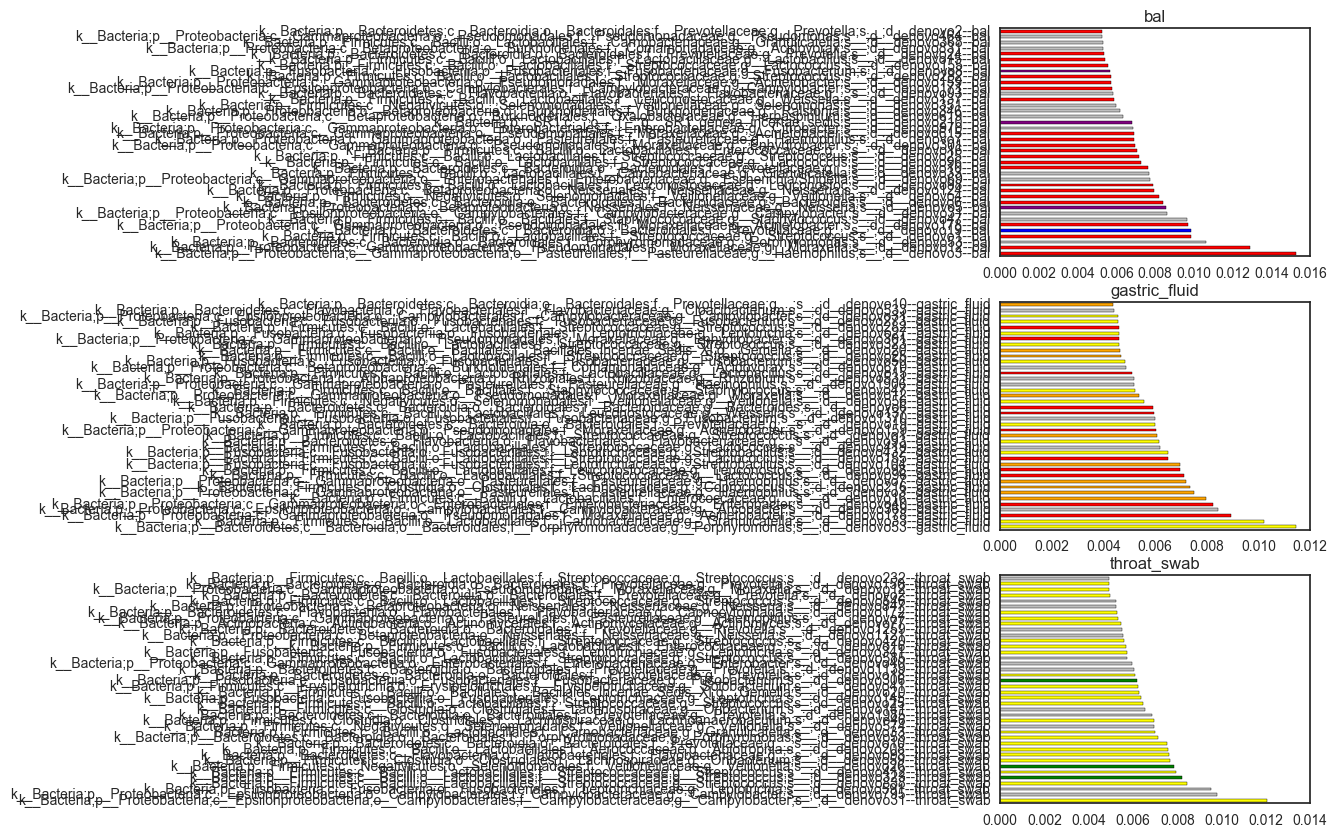

In [21]:
# Replot feature importances, but this time color by whether or not it's shared
fig, ax = plt.subplots(3, 1, figsize=(4,10))
i = 0
for g, subdf in features.groupby('classifier'):
    subdf = subdf.sort_values(by='importance', ascending=False).head(40)
    subdf['importance'].plot(kind='barh', color=subdf['color'], ax=ax[i])
    ax[i].set_title(g)
    ax[i].set_xlabel('')
    ax[i].set_yticklabels(subdf['feature'])
    i += 1

In [22]:
# Wait, what percent of OTUs within each site comparison are considered shared?
exchange.groupby('site_comparison')['shared'].sum() / exchange.groupby('site_comparison').size()

site_comparison
bal_gastric       0.475610
bal_throat        0.112150
throat_gastric    0.564815
dtype: float64

In [23]:
features.head()

,classifier,feature,importance,shared_type,color
0,bal,k__;p__;c__;o__;f__;g__;s__;d__denovo120--bal,0.00005,nan,0.75
1,bal,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,0.00000,nan,0.75
2,bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1...,0.00048,nan,0.75
3,bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1...,0.00019,nan,0.75
4,bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1...,0.00000,nan,0.75


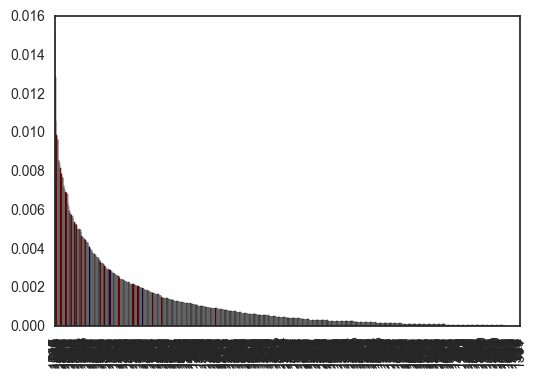

In [31]:
tmp = features.query('classifier == "bal"').query('importance > 0').sort_values(by='importance', ascending=False)
tmp['importance'].plot(kind='bar', color=tmp['color'])

Hmm... I don't think this is a particularly fruitful avenue to go down. Let's look instead at the phylogeny of the important features.

## Next steps

**Feature investigation**

* Put the features on a tree, see if there are patterns
* Consider fisher test on (is feature important?) vs. (is feature a shared OTU?) to see if the shared OTUs actually matter

**Classifier follow up**   
I need to re-visit my site-combination classifiers from forever ago. It seems that combining the 16S data directly does indeed improve the classifiers. Let's dig into it again.

- make classifiers based on all combinations of sites (including single-site, and all three sites)
- make the same classifiers, but with the labels shuffled
- do this like 10 times for each classifier
- plot AUC distribution (boxplots, or hist I guess...)

For each classifier, track:
- sites used
- classifier replicate
- number of patients (aspirators and non-aspirators)
- the usual stuff: AUC, fisher p, FPR, TPR, predictions, confusion matrix, etc...

Code to do most of this is already in `2016-09-26.aspiration_throat_gastric.py` (but should use the tidy data principles I've learned since then :) )